# DQN Atari Paper Implementation

In [14]:
# ! pip install gymnasium[atari] torch numpy opencv-python matplotlib

In [15]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

In [16]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

## Hyperparameters
As per the paper, we use certain hyperparameters that were tuned across various Atari games.

In [17]:
LEARNING_RATE = 0.00025  # Paper used a similar learning rate
DISCOUNT_FACTOR = 0.99  # The γ discount factor as mentioned in the paper
REPLAY_MEMORY_SIZE = 150_000  # Large replay buffer as described, but not too large
BATCH_SIZE = 32  # Minibatch size for training
TARGET_UPDATE_FREQ = 1_250  # C steps for target network update
FRAME_SKIP = 4  # Number of frames skipped
MIN_EPSILON = 0.1  # Minimum value of epsilon (for more exploitation)
MAX_EPSILON = 1.0  # Starting value of epsilon (for exploration)
MAX_STEPS = 500_000  # Total training episodes (Space Invaders)
REPLAY_START_SIZE = 50_000  # Size of replay memory before starting training
SAVE_FREQUENCY = 50_000  # Save model every 50k steps

## Deep Q-Network Architecture
Referring to the paper's architecture (3 convolutional layers, followed by fully connected layers)

In [18]:
class DQN(torch.nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv = torch.nn.Sequential(
            # Convolution layers (as per paper), input: 84x84x4 image
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4),
            # Using ReLU activations as specified in the paper
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
        )

        self.linear = torch.nn.Sequential(
            torch.nn.Linear(7 *  7 * 64 , 512),
            torch.nn.ReLU(),
            # Final fully connected layer with one output for each action
            torch.nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return x

## Custom Wrappers
We use custom wrappers using gymnasium's API.
The paper describes preprocessing the input frames by converting them to grayscale, resizing, normalizing and stacking the last 4 frames to capture motion. We will use the same preprocessing steps.

In [19]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super(FrameSkip, self).__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and take the last observation."""
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done or truncated:
                break
        return obs, total_reward, done, truncated, info


class GrayScaleResize(gym.ObservationWrapper):
    def __init__(self, env):
        """Convert the observations to grayscale and resize to 84x84."""
        super(GrayScaleResize, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84), dtype=np.uint8
        )

    def observation(self, obs):
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)  # Resize to 84x84
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        """Stack `k` last frames."""
        super(FrameStack, self).__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, shp[0], shp[1]), dtype=np.uint8
        )

    def reset(self):
        obs, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_ob(), info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        return np.array(self.frames)


class NormalizeObs(gym.ObservationWrapper):
    """Normalize observations to the range [0, 1]."""

    def __init__(self, env):
        super(NormalizeObs, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=1.0, shape=env.observation_space.shape, dtype=np.float32
        )

    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

## Replay Memory
We implement an experience replay buffer as described in the paper to store past experiences and sample them randomly during training to break the correlation between consecutive frames.

In [20]:
class ReplayBuffer:
    def __init__(self, size, obs_shape, action_shape):
        self.size = size
        self.obs_shape = obs_shape
        self.action_shape = action_shape

        self.t_obs = np.empty((size, *obs_shape), dtype=np.uint8)
        self.t1_obs = np.empty((size, *obs_shape), dtype=np.uint8)
        self.actions = np.empty((size, *action_shape), dtype=np.uint8)
        self.rewards = np.empty(size, dtype=np.float16)
        self.dones = np.empty(size, dtype=np.bool_)

        self.idx = 0
        self.current_size = 0

    def append(self, t_obs, t1_obs, actions, reward, done):
        self.t_obs[self.idx] = t_obs
        self.t1_obs[self.idx] = t1_obs
        self.actions[self.idx] = actions
        self.rewards[self.idx] = reward
        self.dones[self.idx] = done

        self.current_size = min(self.current_size + 1, self.size)
        self.idx = (self.idx + 1) % self.size

    def sample(self, batch_size):
        ids = np.random.choice(self.current_size, batch_size, replace=False)
        batch = (
            self.t_obs[ids],
            self.t1_obs[ids],
            self.actions[ids],
            self.rewards[ids],
            self.dones[ids],
        )

        return tuple(
            torch.as_tensor(item, dtype=torch.float32).to(device) for item in batch
        )

    def __len__(self):
        return self.current_size


## Epsilon-greedy action selection
This function selects an action using epsilon-greedy policy as mentioned in the paper.

In [21]:
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:  # Explore
        return random.choice(action_space)
    else:  # Exploit
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
            return policy_net(state).argmax(dim=1).item()

## Target Network Update
Target network helps stabilize learning. The paper mentions that the target network is updated every C steps.
Unlike the paper here we will use a Double DQN approach where the target network is updated with the weights of the main network every C steps. This helps in reducing overestimation of Q-values and training time.

In [22]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())  # Sync the weights

## Gymnasium Environment Setup

Here we set up the gym environment, by selecting the Breakout game.

In [23]:
def make_env(env_id, render_mode=None, frame_skip=4):
    """Create environment with preprocessing wrappers."""
    env = gym.make(env_id, render_mode=render_mode, frameskip=1)
    env = FrameSkip(env, skip=frame_skip)  # Frame skipping (skip 4 frames)
    env = GrayScaleResize(env)  # Convert frames to grayscale and resize to 84x84
    env = NormalizeObs(env)  # Normalize pixel values to [0, 1]
    env = FrameStack(env, k=4)  # Stack the last 4 frames
    return env


env = make_env("ALE/Breakout-v5")
action_space = [i for i in range(env.action_space.n)]

# Initialize policy and target networks
policy_net = DQN(len(action_space)).to(device)
target_net = DQN(len(action_space)).to(device)
update_target(policy_net, target_net)  # First sync

# Instead of RMSprop, we use Adam as the optimizer because we won't train
# as much as the paper did
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(REPLAY_MEMORY_SIZE, (4, 84, 84), (1,))

epsilon = MAX_EPSILON  # Starting value of epsilon

In [24]:
summary(policy_net.to("cpu"), input_size=(4, 84, 84), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 512]       1,606,144
              ReLU-9                  [-1, 512]               0
           Linear-10                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.35
Params size (MB): 6.43
Estimat

In [25]:
policy_net.to(device)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

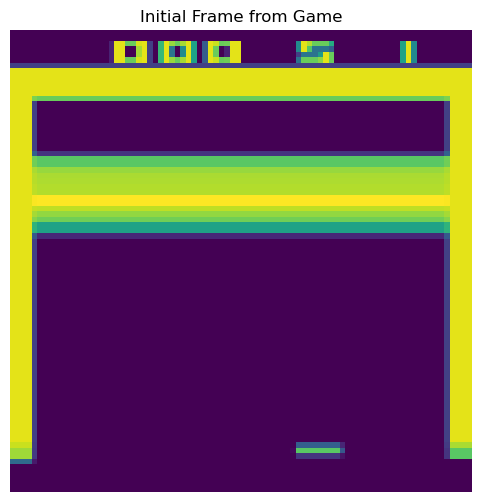

In [26]:
# Reset the environment to get the initial state
initial_state = env.reset()

# Extract the first frame from the stacked frames
first_frame = initial_state[0]

# Plot the first frame using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(first_frame[0])
plt.title("Initial Frame from Game")
plt.axis("off")
plt.show()

## Training Loop
Here, we follow the methodology from the paper, by putting all the above components together to train the DQN agent on the Atari game.

In [14]:
total_steps = 0

plot_infos = {
    "total_steps": [],
    "total_reward": [],
    "epsilon": [],
    "total_q_values": [],
    "total_loss": [],
}

progress_bar = tqdm(range(MAX_STEPS), desc="Training Progress")

while total_steps < MAX_STEPS:
    state, info = env.reset()  # Reset environment to initial state

    total_reward = 0
    total_q_values = 0
    total_loss = 0

    while True:
        action = select_action(state, policy_net, epsilon, action_space)

        # Step the environment
        next_state, reward, done, truncated, _ = env.step(action)

        # Clip the reward to be in the range [-1, 1] as mentioned in the paper
        reward = np.sign(reward)

        # Store the transition in replay memory
        replay_buffer.append(state, next_state, action, reward, done)

        state = next_state
        total_reward += reward
        total_steps += 1

        # Only start training when replay memory has enough samples
        if len(replay_buffer) >= REPLAY_START_SIZE:
            if total_steps % 4 == 0: # Update every 4 steps like in the paper
                # Sample minibatch from replay buffer
                batch = replay_buffer.sample(BATCH_SIZE)

                batch_state, batch_next_state, batch_action, batch_reward, batch_done = (
                    batch
                )
                
                optimizer.zero_grad()
                
                # Compute Q targets
                q_values = policy_net(batch_state).gather(1, batch_action.long())
                next_q_values = target_net(batch_next_state).max(1)[0].detach()
                target_q_values = batch_reward + (
                    DISCOUNT_FACTOR * next_q_values * (~batch_done.bool())
                )

                loss = torch.nn.functional.huber_loss(q_values, target_q_values.unsqueeze(1))

                total_q_values += q_values.mean().item()
                total_loss += loss.item()

                # Backpropagate and update the network
                loss.backward()
                optimizer.step()

            # Update target network periodically
            if total_steps % TARGET_UPDATE_FREQ == 0:
                update_target(policy_net, target_net)

            # Save checkpoints every SAVE_FREQUENCY steps
            if total_steps % SAVE_FREQUENCY == 0:
                torch.save(
                    policy_net.state_dict(), f"checkpoints/checkpoint_{total_steps}.pth"
                )

        if done or truncated:
            break

    # Append the total reward for tracking
    plot_infos["total_reward"].append(total_reward)
    # Decay epsilon for exploration-exploitation tradeoff
    epsilon = max(MIN_EPSILON, ((0.1 - 1.0) / (MAX_STEPS)) * total_steps + 1.0)
    plot_infos["epsilon"].append(epsilon)
    plot_infos["total_steps"].append(total_steps)
    plot_infos["total_q_values"].append(total_q_values / total_steps)
    plot_infos["total_loss"].append(total_loss / total_steps)

    progress_bar.set_description(
        f"R: {plot_infos['total_reward'][-1]}, ε: {plot_infos['epsilon'][-1]:.5f}, RSize: {len(replay_buffer)} Q-value: {plot_infos['total_q_values'][-1]:.5f}, Loss: {plot_infos['total_loss'][-1]:.5f}"
    )
    progress_bar.update(plot_infos["total_steps"][-1] - progress_bar.n)

progress_bar.close()
env.close()

Training Progress:   0%|          | 0/500000 [00:00<?, ?it/s]2024-10-01 19:10:41.158 python[87508:2561613] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-01 19:10:41.158 python[87508:2561613] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
R: 1.0, ε: 0.99089, RSize: 1686 Q-value: 0.00000, Loss: 0.00000:   0%|          | 1686/500000 [00:58<4:45:12, 29.12it/s]

## Training Progress

Here is the training progress of the DQN agent on the Breakout game.

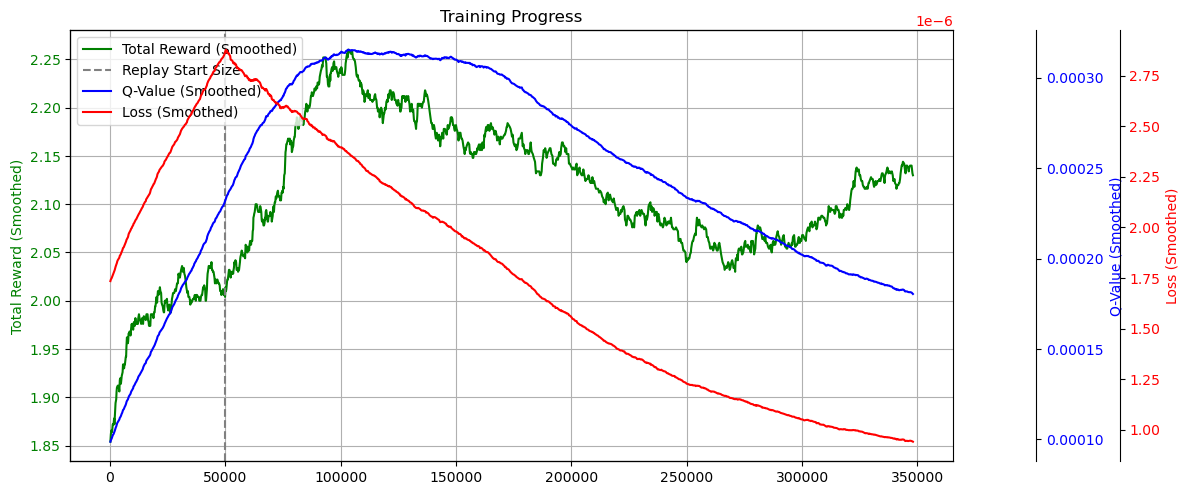

: 

In [15]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


# Define the window size for moving average
window_size = 500

# Calculate the moving averages
smoothed_rewards = moving_average(plot_infos["total_reward"], window_size)
smoothed_q_values = moving_average(plot_infos["total_q_values"], window_size)
smoothed_loss = moving_average(plot_infos["total_loss"], window_size)

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot smoothed total rewards
ax1.plot(
    plot_infos["total_steps"][: len(smoothed_rewards)],
    smoothed_rewards,
    label="Total Reward (Smoothed)",
    color="green",
)
ax1.set_ylabel("Total Reward (Smoothed)", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(True)  # Add grid to ax1

# Add vertical line at REPLAY_START_SIZE
ax1.axvline(REPLAY_START_SIZE, color='gray', linestyle='--', label='Replay Start Size')

# Create another secondary y-axis for smoothed Q-values
ax2 = ax1.twinx()
ax2.spines["right"].set_position(("outward", 60))
ax2.plot(
    plot_infos["total_steps"][: len(smoothed_q_values)],
    smoothed_q_values,
    label="Q-Value (Smoothed)",
    color="blue",
)
ax2.set_ylabel("Q-Value (Smoothed)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Create another secondary y-axis for smoothed loss
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 120))
ax3.plot(
    plot_infos["total_steps"][: len(smoothed_loss)],
    smoothed_loss,
    label="Loss (Smoothed)",
    color="red",
)
ax3.set_ylabel("Loss (Smoothed)", color="red")
ax3.tick_params(axis="y", labelcolor="red")

# Combine legends from all axes
lines, labels = [], []

for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

ax1.legend(lines, labels, loc="upper left")

fig.tight_layout()
plt.title("Training Progress")
plt.show()

## Result
Here is the training playing each 50000 steps.

In [27]:
import gymnasium as gym


# Create the Breakout environment with rendering enabled
env = make_env("ALE/Breakout-v5", render_mode="human")

best_model_path = "checkpoints/checkpoint_500000.pth"
policy_net = policy_net.to(device)
policy_net.load_state_dict(torch.load(best_model_path, map_location=device))
policy_net.eval()

# Reset the environment to get the initial observation and info
observation, info = env.reset()

for _ in range(10000):  # Run for 10,000 steps
    # Sample a random action from the action space
    # If the model outputs always the same action, the breakout game will get stuck
    # We introduce a small probability of random actions to prevent this
    action = select_action(observation, policy_net, 0.03, action_space)
    
    # Take the action and receive the new state and other info
    observation, reward, terminated, truncated, info = env.step(action)
    
    # If the episode is over, reset the environment
    if terminated or truncated:
        observation, info = env.reset()

# Close the environment when done
env.close()

/var/folders/mv/3fqdyl697kg4mqs3tkmd7gs80000gn/T/ipykernel_87592/966880056.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(best_mod

: 